In [1]:
import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from flopy.utils.reference import SpatialReference
from SimPEG import Mesh
import glob
from  pyproj import Proj
from shapely.geometry import Point, Polygon


########## INPUT #############
# it = int(sys.argv[1])-1
# f_varlist = Path(sys.argv[2])
# job_id = sys.argv[3]
# job_id_conc = int(sys.argv[4])

it=1
f_varlist = Path('../data/PriorModel/varlist.pkl')
job_id = 'test'
job_id_conc  = 3845000
print('inputs:','it',it,'f_varlist',f_varlist,'job_id',job_id,'job_id_conc',job_id_conc)
########## INPUT #############




if sys.platform.lower()=='linux':
    datadir = Path('/scratch/users/ianpg/SWIlarge/data')
    workdir = Path('/scratch/users/ianpg/SWIlarge/work')
    MPSdir = datadir.joinpath('lith/sgems/MPS')
    lithdir = datadir.joinpath('lith/sgems/')
    GISdir = datadir.joinpath('GIS')
    priordir = datadir.joinpath('PriorModel')
elif sys.platform.lower()=='darwin':
    datadir = Path('../data')
    workdir = Path('../work')
    MPSdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS')
    GISdir = datadir.joinpath('GIS')
    lithdir = datadir.joinpath('lith/sgems/')
    priordir = datadir.joinpath('PriorModel')


nmgwmdir_cal = datadir.joinpath('Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
figdir = workdir.joinpath('figs')
outputdir = workdir.joinpath('output')


import config



p = Proj("epsg:26910")
xll=595855
yll = 4059438
rotation = -13.5



#%% Useful functions

def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)




print('loading seawat models and variables')

m_nm= flopy.modflow.Modflow.load('/Volumes/Samsung_T5/ProjectsLocal/SWIlarge/work/nmgwm_seawat/nmgwm_seawat_light.nam',version='mf2k',verbose=False,check=False)
# m = flopy.modflow.Modflow.load(nmgwmdir_uncal.joinpath('C1-12_copy.nam').as_posix(),version='mf2k',verbose=False,check=False,model_ws=outputdir.joinpath('C1').as_posix())
m_nm.exe_name = config.mf2000exe
if not m_nm.DIS.lenuni==2:
    m_nm.DIS.delr *= .3048
    m_nm.DIS.delc *= .3048
    m_nm.DIS.top *= .3048
    m_nm.DIS.botm *= .3048
m_nm.DIS.lenuni = 2
m_nm.DIS.itmuni=4
m_nm.DIS.rotation=-13.5
# m_nm.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_nm.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_nm.DIS.proj4_str = p.srs
m_nm.modelgrid.set_coord_info(xoff=xll, yoff=yll, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')



flopy is installed in /Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/flopy
inputs: it 1 f_varlist ../data/PriorModel/varlist.pkl job_id test job_id_conc 3845000
system: darwin
loading seawat models and variables


In [2]:
model_ws_SV = workdir.joinpath('SV')
rows_SV = np.load(model_ws_SV.joinpath('rows.npy'))

mgridx = m_nm.modelgrid.xvertices[rows_SV,:]
mgridy = m_nm.modelgrid.yvertices[rows_SV,:]

coords = [(mgridx[0,0], mgridy[0,0]),
          (mgridx[-1,0], mgridy[-1,0]),
          (mgridx[-1,-1], mgridy[-1,-1]),
          (mgridx[0,-1], mgridy[0,-1])
         ]
SV_poly = Polygon(coords)


model_ws_NM = workdir.joinpath('NM')
rows_NM = np.load(model_ws_NM.joinpath('rows.npy'))

mgridx = m_nm.modelgrid.xvertices[rows_NM,:]
mgridy = m_nm.modelgrid.yvertices[rows_NM,:]

coords = [(mgridx[0,0], mgridy[0,0]),
          (mgridx[-1,0], mgridy[-1,0]),
          (mgridx[-1,-1], mgridy[-1,-1]),
          (mgridx[0,-1], mgridy[0,-1])
         ]
NM_poly = Polygon(coords)




In [5]:
df = pd.read_pickle('/Volumes/Samsung_T5/ProjectsLocal/SWIlarge/data/AEM/processed_df_1719.pkl')

In [9]:
xy = df.loc[df.skytem_type==304,['UTMX','UTMY']].values

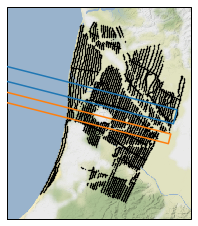

In [16]:
import cartopy
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colorbar
import seaborn as sns
transform = ccrs.UTM(10)

# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure(figsize=(3.3,5))
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

ax.add_image(stamen_terrain, 11)


# ax.set_extent([600000., 620000.,4052000., 4075962.], crs=transform)
ax.set_extent([600000., 620000.,4052000., 4075000.], crs=transform)
ax.grid(True)


plt.plot(*SV_poly.exterior.xy,transform=transform,zorder=5)
plt.plot(*NM_poly.exterior.xy,transform=transform,zorder=5)

plt.scatter(xy[:,0],xy[:,1],c='k',s=.05,transform=transform,zorder=4)

plt.savefig(figdir.joinpath('fieldsite_wboxes.eps'),dpi=300,bbox_inches='tight')
plt.show()

In [25]:
np.linspace(4052000., 4075000,5)

array([4052000., 4057750., 4063500., 4069250., 4075000.])

In [31]:
strt = 4052000
stp =4075000

lvls = np.arange(strt-2000,stp+1,5000)

In [33]:
lvls
pcts = (lvls - strt)/(stp-strt)

In [37]:
(lvls/1000).astype(int)

array([4050, 4055, 4060, 4065, 4070, 4075])

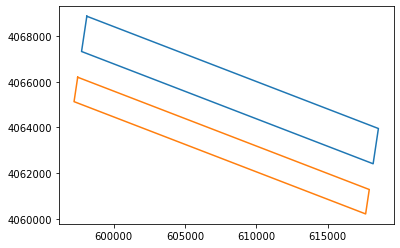

In [5]:
ax.set_extent([600000., 620000.,4052000., 4075000.], crs=transform)
